<a href="https://colab.research.google.com/github/Suraba03/ml_san_francisco_permits/blob/main/san_fancisco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import data and first glance

In [275]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [276]:
!ls

drive  sample_data


In [277]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/san_francisco/Building_Permits.csv', low_memory=False)

In [278]:
pd.set_option('display.max_columns', None)

In [279]:
df.head()

,Permit Number,Permit Type,Permit Type Definition,Permit Creation Date,Block,Lot,Street Number,Street Number Suffix,Street Name,Street Suffix,Unit,Unit Suffix,Description,Current Status,Current Status Date,Filed Date,Issued Date,Completed Date,First Construction Document Date,Structural Notification,Number of Existing Stories,Number of Proposed Stories,Voluntary Soft-Story Retrofit,Fire Only Permit,Permit Expiration Date,Estimated Cost,Revised Cost,Existing Use,Existing Units,Proposed Use,Proposed Units,Plansets,TIDF Compliance,Existing Construction Type,Existing Construction Type Description,Proposed Construction Type,Proposed Construction Type Description,Site Permit,Supervisor District,Neighborhoods - Analysis Boundaries,Zipcode,Location,Record ID
0,201505065519,4,sign - erect,05/06/2015,0326,023,140,NaN,Ellis,St,NaN,NaN,"ground fl facade: to erect illuminated, electr...",expired,12/21/2017,05/06/2015,11/09/2015,NaN,11/09/2015,NaN,6.0,NaN,NaN,NaN,11/03/2016,4000.0,4000.0,tourist hotel/motel,143.0,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.785719256680785, -122.40852313194863)",1380611233945
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,0.0,NaN,remove (e) awning and associated signs.,issued,08/03/2017,04/19/2016,08/03/2017,NaN,08/03/2017,NaN,7.0,NaN,NaN,NaN,12/03/2017,1.0,500.0,tourist hotel/motel,NaN,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
2,201605278609,3,additions alterations or repairs,05/27/2016,0595,203,1647,NaN,Pacific,Av,NaN,NaN,installation of separating wall,withdrawn,09/26/2017,05/27/2016,NaN,NaN,NaN,NaN,6.0,6.0,NaN,NaN,NaN,20000.0,NaN,retail sales,39.0,retail sales,39.0,2.0,NaN,1.0,constr type 1,1.0,constr type 1,NaN,3.0,Russian Hill,94109.0,"(37.7946573324287, -122.42232562979227)",1424856504716
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,0.0,NaN,repair dryrot & stucco at front of bldg.,complete,07/24/2017,11/07/2016,07/18/2017,07/24/2017,07/18/2017,NaN,2.0,2.0,NaN,NaN,07/13/2018,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,NaN,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,NaN,NaN,demolish retail/office/commercial 3-story buil...,issued,12/01/2017,11/28/2016,12/01/2017,NaN,11/20/2017,NaN,3.0,NaN,NaN,NaN,12/01/2018,100000.0,100000.0,retail sales,NaN,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992


In [280]:
df.shape

(198900, 43)

# preprocessing

## Zero stage

let's remove white spaces from columns names

In [281]:
df = df.rename(lambda name: name.replace(" ", ""), axis='columns')

let's divide features list into two groups: numerical and categorical

In [282]:
num_cols = [col for col in df.columns if "int" in str(df[col].dtype) or "float" in str(df[col].dtype)]
cat_cols = [col for col in df.columns if "object" == str(df[col].dtype) and col != "CurrentStatus"]
print(num_cols)
print(cat_cols)

['PermitType', 'StreetNumber', 'Unit', 'NumberofExistingStories', 'NumberofProposedStories', 'EstimatedCost', 'RevisedCost', 'ExistingUnits', 'ProposedUnits', 'Plansets', 'ExistingConstructionType', 'ProposedConstructionType', 'SupervisorDistrict', 'Zipcode', 'RecordID']
['PermitNumber', 'PermitTypeDefinition', 'PermitCreationDate', 'Block', 'Lot', 'StreetNumberSuffix', 'StreetName', 'StreetSuffix', 'UnitSuffix', 'Description', 'CurrentStatusDate', 'FiledDate', 'IssuedDate', 'CompletedDate', 'FirstConstructionDocumentDate', 'StructuralNotification', 'VoluntarySoft-StoryRetrofit', 'FireOnlyPermit', 'PermitExpirationDate', 'ExistingUse', 'ProposedUse', 'TIDFCompliance', 'ExistingConstructionTypeDescription', 'ProposedConstructionTypeDescription', 'SitePermit', 'Neighborhoods-AnalysisBoundaries', 'Location']


In [283]:
target = "CurrentStatus"

these CurrentStatus values are useless because they are still in process, so that let's **drop them**

In [284]:
df = df[(df['CurrentStatus'] != 'filed') &
       (df['CurrentStatus'] != 'withdrawn') &
       (df['CurrentStatus'] != 'expired') &
       (df['CurrentStatus'] != 'plancheck') &
       (df['CurrentStatus'] != 'disapproved') &
       (df['CurrentStatus'] != 'appeal') ]

In [285]:
df.shape

(183713, 43)

Well we've lost apprx 15k rows, not so bad

Now let's divide values in **CurrentStatus** into two groups:
+ positive (value 1): application was rejected))
+ negative (value 0): application was approved

So lets consider ```[cancelled, suspend, revoked]``` as a **rejected** applications and ```[complete, issued, approved, reinstated, incomplete]``` as **approved** ones.

In [286]:
df['CurrentStatus'] = df['CurrentStatus'].map({'cancelled': 1, 'suspend': 1, 'revoked': 1,
                                                 'complete': 0, 'issued': 0, 'approved': 0, 
                                                 'reinstated': 0, 'incomplete': 0});

In [287]:
df['CurrentStatus'] = df['CurrentStatus'].astype('int64');

In [288]:
import seaborn as sns

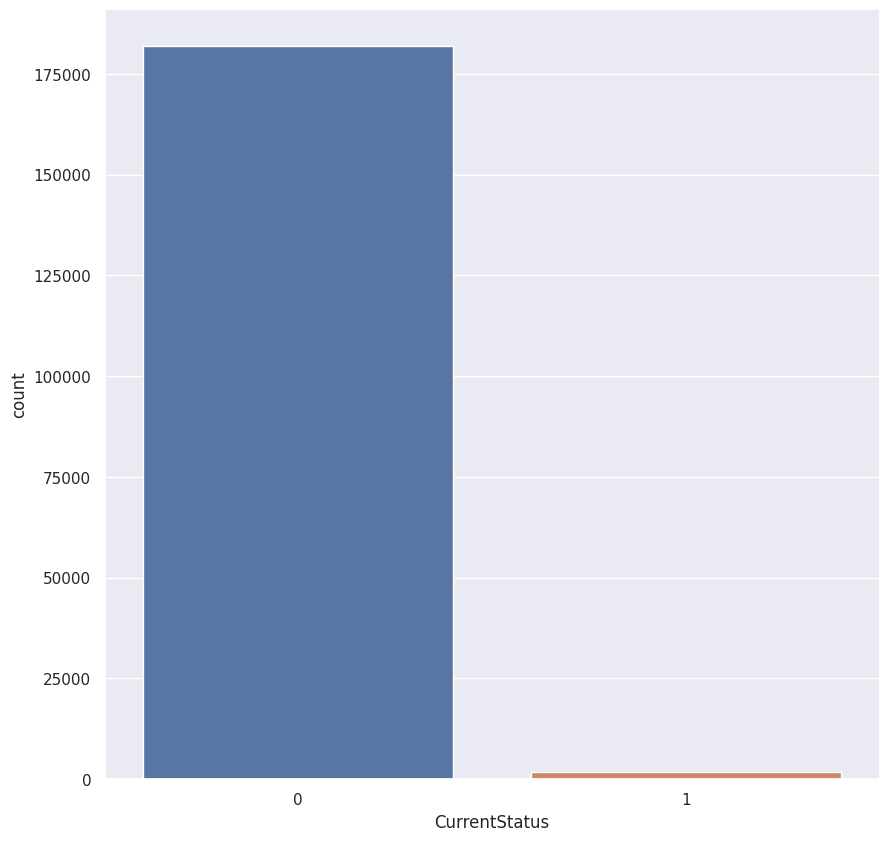

In [289]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(x=target, data=df);

In [290]:
df[target].value_counts() / df.shape[0]

0    0.990316
1    0.009684
Name: CurrentStatus, dtype: float64

just a sanity check

In [291]:
set(num_cols+cat_cols + [target]) == set(df.columns)

True

## Missing values (new)

### DF


In [292]:
df.head()

,PermitNumber,PermitType,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetNumberSuffix,StreetName,StreetSuffix,Unit,UnitSuffix,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,CompletedDate,FirstConstructionDocumentDate,StructuralNotification,NumberofExistingStories,NumberofProposedStories,VoluntarySoft-StoryRetrofit,FireOnlyPermit,PermitExpirationDate,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,TIDFCompliance,ExistingConstructionType,ExistingConstructionTypeDescription,ProposedConstructionType,ProposedConstructionTypeDescription,SitePermit,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,Zipcode,Location,RecordID
1,201604195146,4,sign - erect,04/19/2016,0306,007,440,NaN,Geary,St,0.0,NaN,remove (e) awning and associated signs.,0,08/03/2017,04/19/2016,08/03/2017,NaN,08/03/2017,NaN,7.0,NaN,NaN,NaN,12/03/2017,1.0,500.0,tourist hotel/motel,NaN,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,3.0,Tenderloin,94102.0,"(37.78733980600732, -122.41063199757738)",1420164406718
3,201611072166,8,otc alterations permit,11/07/2016,0156,011,1230,NaN,Pacific,Av,0.0,NaN,repair dryrot & stucco at front of bldg.,0,07/24/2017,11/07/2016,07/18/2017,07/24/2017,07/18/2017,NaN,2.0,2.0,NaN,NaN,07/13/2018,2000.0,2000.0,1 family dwelling,1.0,1 family dwelling,1.0,2.0,NaN,5.0,wood frame (5),5.0,wood frame (5),NaN,3.0,Nob Hill,94109.0,"(37.79595867909168, -122.41557405519474)",1443574295566
4,201611283529,6,demolitions,11/28/2016,0342,001,950,NaN,Market,St,NaN,NaN,demolish retail/office/commercial 3-story buil...,0,12/01/2017,11/28/2016,12/01/2017,NaN,11/20/2017,NaN,3.0,NaN,NaN,NaN,12/01/2018,100000.0,100000.0,retail sales,NaN,NaN,NaN,2.0,NaN,3.0,constr type 3,NaN,NaN,NaN,6.0,Tenderloin,94102.0,"(37.78315261897309, -122.40950883997789)",144548169992
5,201706149344,8,otc alterations permit,06/14/2017,4105,009,800,NaN,Indiana,St,NaN,NaN,evac maps,0,07/06/2017,06/14/2017,07/06/2017,NaN,07/06/2017,NaN,5.0,5.0,NaN,Y,07/01/2018,4000.0,4000.0,apartments,326.0,apartments,326.0,2.0,NaN,1.0,constr type 1,1.0,constr type 1,NaN,10.0,Potrero Hill,94107.0,"(37.75922331346539, -122.39170402628598)",1466911170855
6,201706300814,8,otc alterations permit,06/30/2017,1739,020,1291,NaN,11th,Av,0.0,NaN,re-roofing,0,07/12/2017,06/30/2017,06/30/2017,07/12/2017,06/30/2017,NaN,3.0,3.0,NaN,NaN,06/25/2018,12000.0,12000.0,apartments,5.0,apartments,5.0,0.0,NaN,5.0,wood frame (5),5.0,wood frame (5),NaN,5.0,Inner Sunset,94122.0,"(37.764145640138565, -122.46875112470363)",1468970403692


In [293]:
# df2 = df.drop(['PermitNumber', 'PermitType', 'StreetSuffix',
#                 'PermitExpirationDate', 'ExistingConstructionType',
#                 'ProposedConstructionType', 'Zipcode', 'Location', 'RecordID'], axis=1)

In [294]:
indices = df['PermitNumber'].str.len() < 8

# get only positive pledges (using their indexes)
df.loc[indices].head()

,PermitNumber,PermitType,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetNumberSuffix,StreetName,StreetSuffix,Unit,UnitSuffix,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,CompletedDate,FirstConstructionDocumentDate,StructuralNotification,NumberofExistingStories,NumberofProposedStories,VoluntarySoft-StoryRetrofit,FireOnlyPermit,PermitExpirationDate,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,TIDFCompliance,ExistingConstructionType,ExistingConstructionTypeDescription,ProposedConstructionType,ProposedConstructionTypeDescription,SitePermit,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,Zipcode,Location,RecordID
7,M803667,8,otc alterations permit,06/30/2017,4789,014,1465,NaN,Revere,Av,NaN,NaN,streetspace,0,06/30/2017,06/30/2017,06/30/2017,NaN,06/30/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,Bayview Hunters Point,94124.0,"(37.73005099023611, -122.38784938916618)",1469035175050
8,M804227,8,otc alterations permit,07/05/2017,1212,054,2094,NaN,Fell,St,NaN,NaN,street space permit,0,07/05/2017,07/05/2017,07/05/2017,NaN,07/05/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,Lone Mountain/USF,94117.0,"(37.772393498502595, -122.45231466824669)",1469198253772
9,M804767,8,otc alterations permit,07/06/2017,1259,016,89,NaN,Alpine,Tr,NaN,NaN,street space,0,07/06/2017,07/06/2017,07/06/2017,NaN,07/06/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Haight Ashbury,94117.0,"(37.7691724293766, -122.43734859051908)",146932394171
10,M805287,8,otc alterations permit,07/06/2017,3541,001,106,NaN,Sanchez,St,NaN,NaN,street space,0,07/06/2017,07/06/2017,07/06/2017,NaN,07/06/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Castro/Upper Market,94114.0,"(37.767349757757145, -122.43140682973024)",1469445246849
11,M805907,8,otc alterations permit,07/07/2017,0829,021,675,NaN,Fell,St,NaN,NaN,street space,0,07/07/2017,07/07/2017,07/07/2017,NaN,07/07/2017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,Hayes Valley,94102.0,"(37.774914087334544, -122.42886839796792)",146961582526


In [295]:
df.drop(df.loc[df.Plansets == 9000].index, inplace=True)

In [296]:
df.loc[~df['CompletedDate'].notnull()].CurrentStatus.value_counts()

0    84762
1     1767
Name: CurrentStatus, dtype: int64

**New boolean feature CompletedDate_was_missing**

In [297]:
df['CompletedDate_was_missing'] = df['CompletedDate'].isnull()

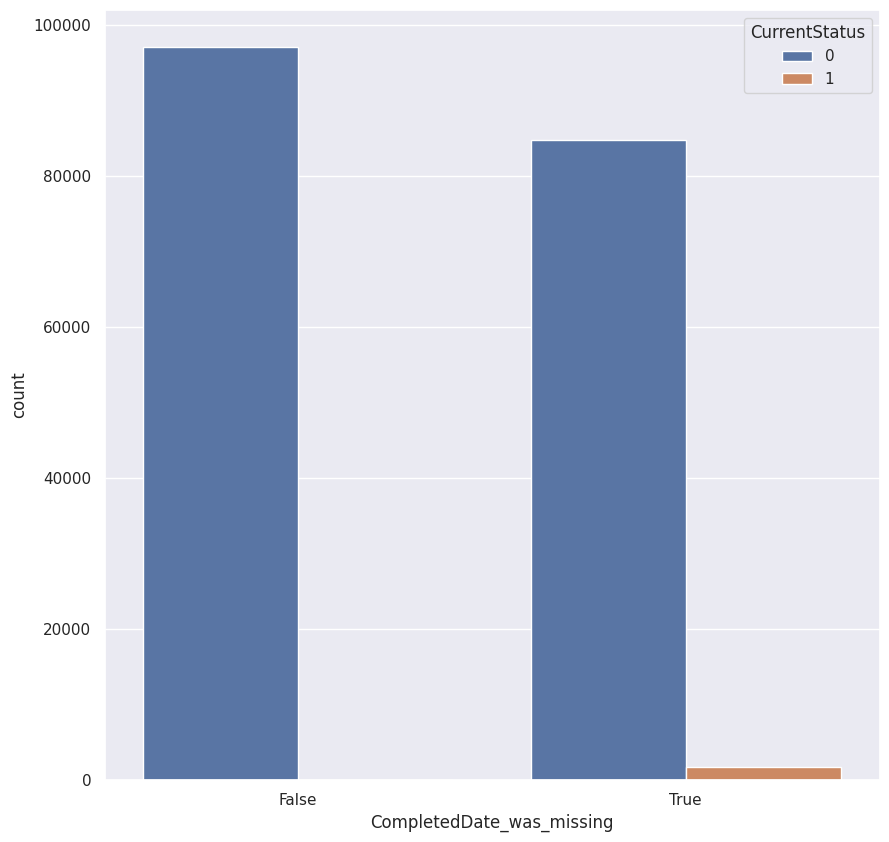

In [298]:
sns.countplot(x="CompletedDate_was_missing", hue="CurrentStatus", data=df);

In [299]:
df.loc[df['IssuedDate'].notnull()].CurrentStatus.value_counts()

0    181152
1      1436
Name: CurrentStatus, dtype: int64

In [300]:
df['IssuedDate_was_missing'] = df['IssuedDate'].isnull()

In [301]:
df.loc[~df['FirstConstructionDocumentDate'].notnull()].CurrentStatus.value_counts()

0    803
1    343
Name: CurrentStatus, dtype: int64

In [302]:
df['FirstConstructionDocumentDate_was_missing'] = df['FirstConstructionDocumentDate'].isnull()

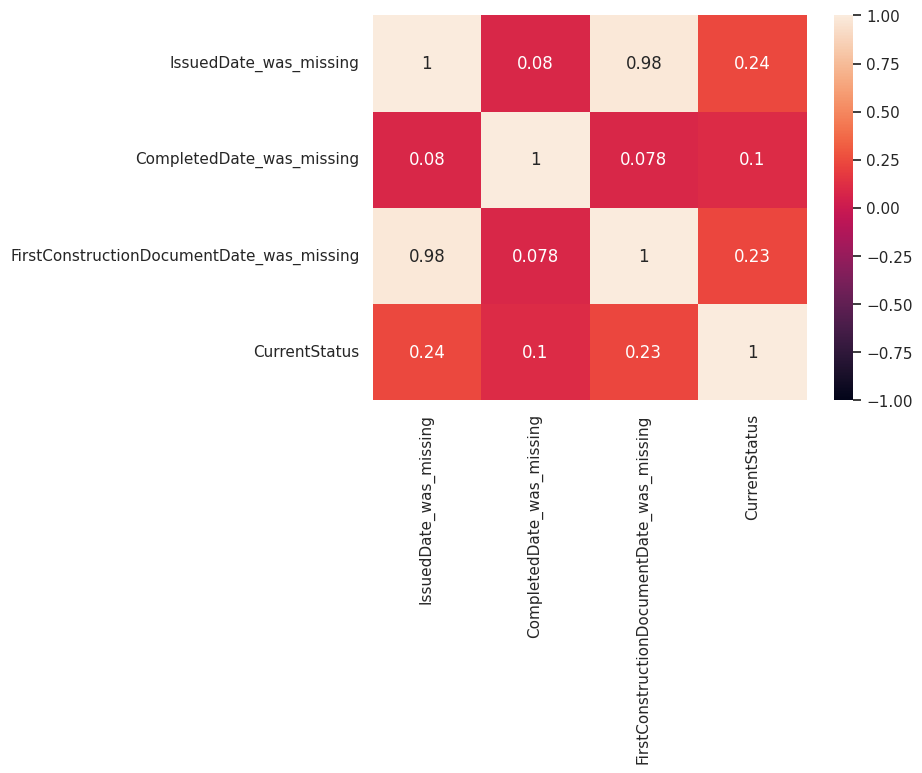

In [303]:
sns.set(rc={'figure.figsize':(7,5)})

corr_matrix = df[["IssuedDate_was_missing", 'CompletedDate_was_missing', 'FirstConstructionDocumentDate_was_missing', 'CurrentStatus']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

**FirstConstructionDate correlates wiht issuedDate therefore we need to drop it**

In [304]:
df.drop(["FirstConstructionDocumentDate_was_missing"], axis=1, inplace=True)

In [305]:
df.loc[df['StructuralNotification'] == 'Y'].CurrentStatus.value_counts(),  df.loc[df['StructuralNotification'] == 'N'].CurrentStatus.value_counts()

(0    5231
 1     136
 Name: CurrentStatus, dtype: int64,
 Series([], Name: CurrentStatus, dtype: int64))

In [306]:
df['StructuralNotification'] = df['StructuralNotification'].fillna('N')

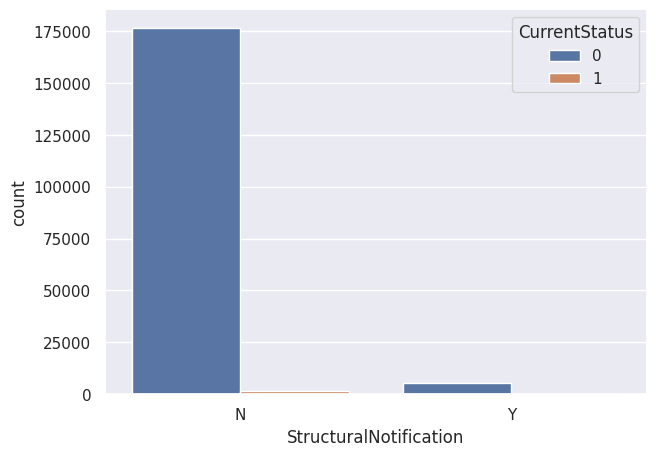

In [307]:
sns.countplot(x="StructuralNotification", hue="CurrentStatus", data=df);

In [308]:
df['StructuralNotification_is_yes'] = df['StructuralNotification'] == 'Y'

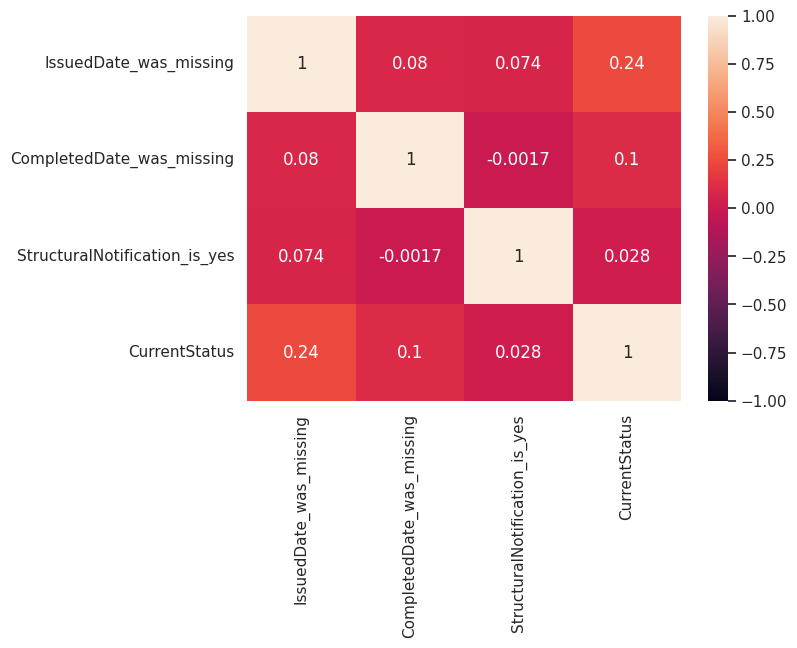

In [309]:
sns.set(rc={'figure.figsize':(7,5)})

corr_matrix = df[["IssuedDate_was_missing", 'CompletedDate_was_missing', 'StructuralNotification_is_yes', 'CurrentStatus']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

In [310]:
df.loc[df['NumberofExistingStories'].notnull()].CurrentStatus.value_counts()

0    141160
1      1718
Name: CurrentStatus, dtype: int64

In [311]:
df['NumberofExistingStories_was_missing'] = df['NumberofExistingStories'].isnull()

In [312]:
df['NumberofStories_alteration'] = df['NumberofProposedStories'].fillna(0) - df['NumberofExistingStories'].fillna(0)

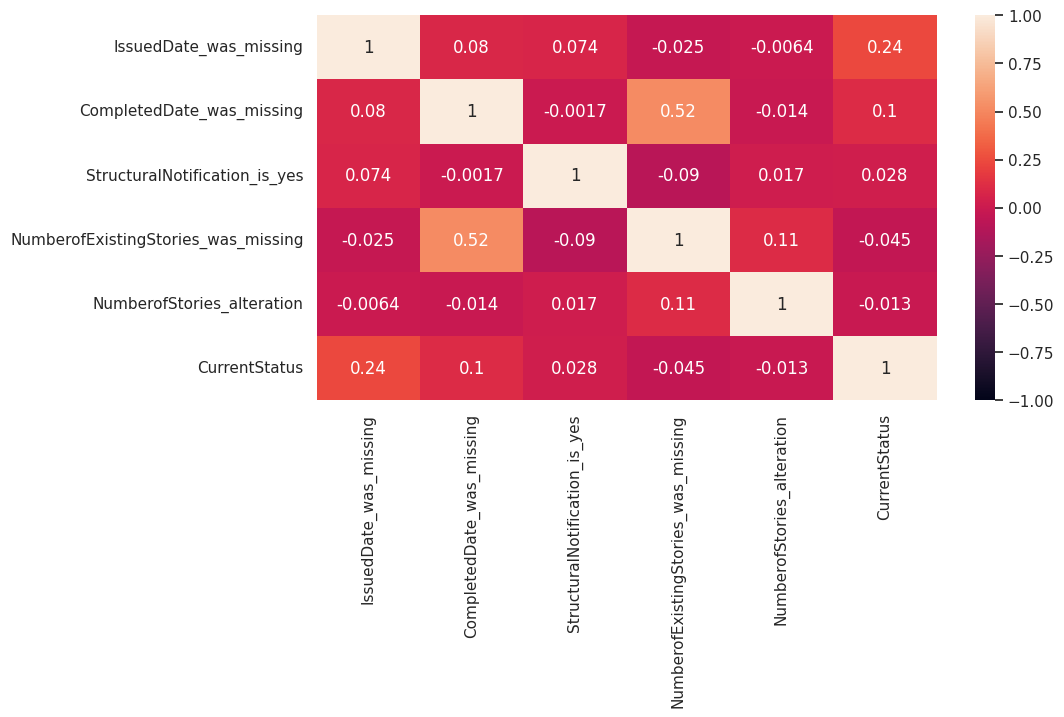

In [313]:
sns.set(rc={'figure.figsize':(10, 5)})

corr_matrix = df[["IssuedDate_was_missing", 'CompletedDate_was_missing', 'StructuralNotification_is_yes', 'NumberofExistingStories_was_missing', "NumberofStories_alteration", 'CurrentStatus']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

In [314]:
df['VoluntarySoft-StoryRetrofit'].unique()

array([nan, 'Y'], dtype=object)

In [315]:
df.loc[~df['VoluntarySoft-StoryRetrofit'].isnull()].CurrentStatus.value_counts()

0    29
Name: CurrentStatus, dtype: int64

In [316]:
df['VoluntarySoft-StoryRetrofit_does_exist'] = df['VoluntarySoft-StoryRetrofit'].notnull()

In [317]:
df.loc[~df['FireOnlyPermit'].notnull()].CurrentStatus.value_counts()

0    163702
1      1716
Name: CurrentStatus, dtype: int64

In [318]:
df['FireOnlyPermit_does_exist'] = df['FireOnlyPermit'].notnull()

In [319]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183712 entries, 1 to 198899
Data columns (total 50 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   PermitNumber                            183712 non-null  object 
 1   PermitType                              183712 non-null  int64  
 2   PermitTypeDefinition                    183712 non-null  object 
 3   PermitCreationDate                      183712 non-null  object 
 4   Block                                   183712 non-null  object 
 5   Lot                                     183712 non-null  object 
 6   StreetNumber                            183712 non-null  int64  
 7   StreetNumberSuffix                      1992 non-null    object 
 8   StreetName                              183712 non-null  object 
 9   StreetSuffix                            181130 non-null  object 
 10  Unit                                    2728

In [320]:
df.loc[~df['PermitExpirationDate'].notnull()].CurrentStatus.value_counts()

0    37718
1      358
Name: CurrentStatus, dtype: int64

In [321]:
df['PermitExpirationDate_was_missing'] = df['PermitExpirationDate'].isnull()

In [322]:
df.loc[df['EstimatedCost'].notnull()].CurrentStatus.value_counts()

0    144883
1      1764
Name: CurrentStatus, dtype: int64

In [323]:
df['EstimatedCost_was_missing'] = df['EstimatedCost'].isnull()

In [324]:
df.drop(['PermitExpirationDate_was_missing'], axis=1, inplace=True)

In [325]:
df.drop(['NumberofExistingStories_was_missing'], axis=1, inplace=True)

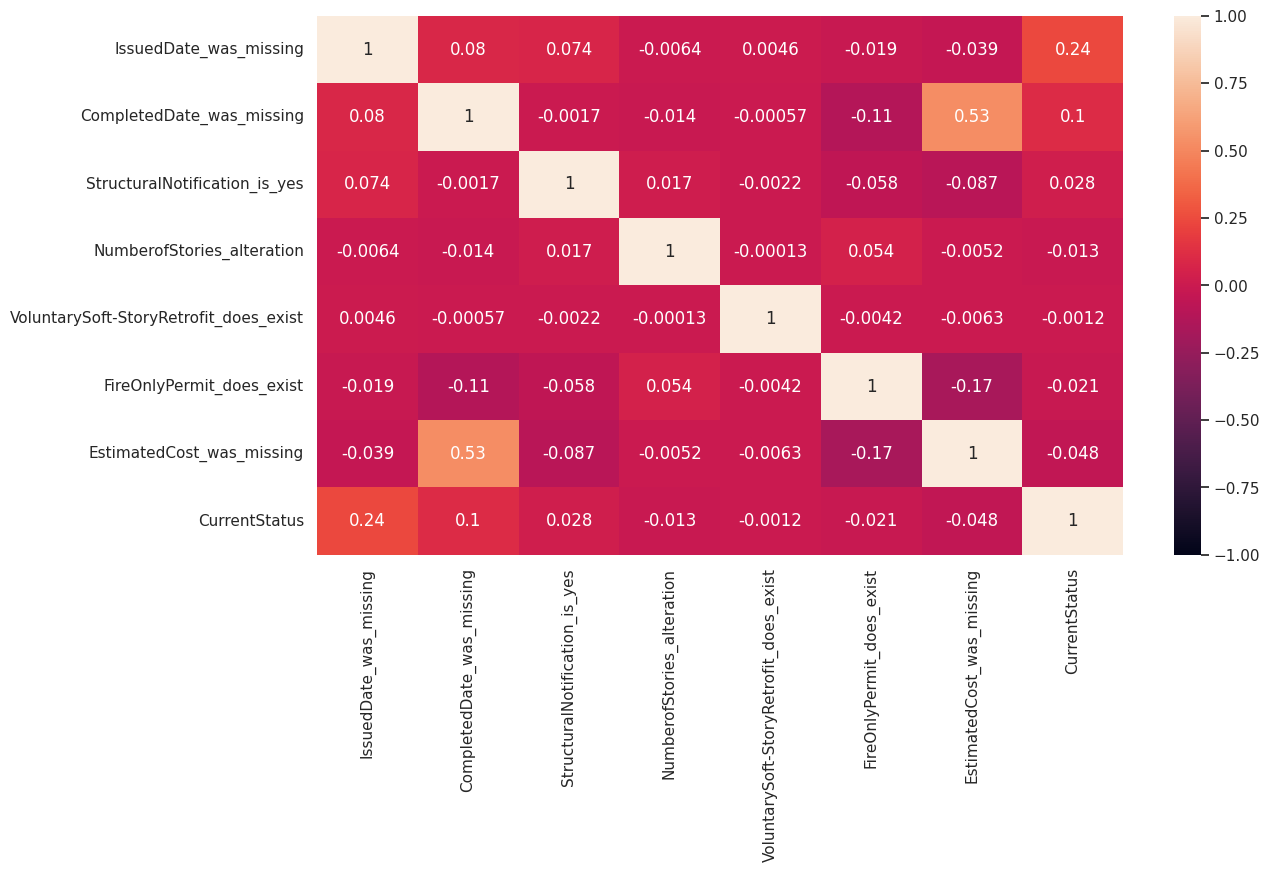

In [326]:
sns.set(rc={'figure.figsize':(13, 7)})

corr_matrix = df[["IssuedDate_was_missing", 'CompletedDate_was_missing', 'StructuralNotification_is_yes', "NumberofStories_alteration", 'VoluntarySoft-StoryRetrofit_does_exist', 'FireOnlyPermit_does_exist', 'EstimatedCost_was_missing', 'CurrentStatus']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

### DF1

Let's remove nans from column EstimatedCost

In [327]:
df1 = df[df['EstimatedCost'].notna()]

In [328]:
df1.shape

(146647, 50)

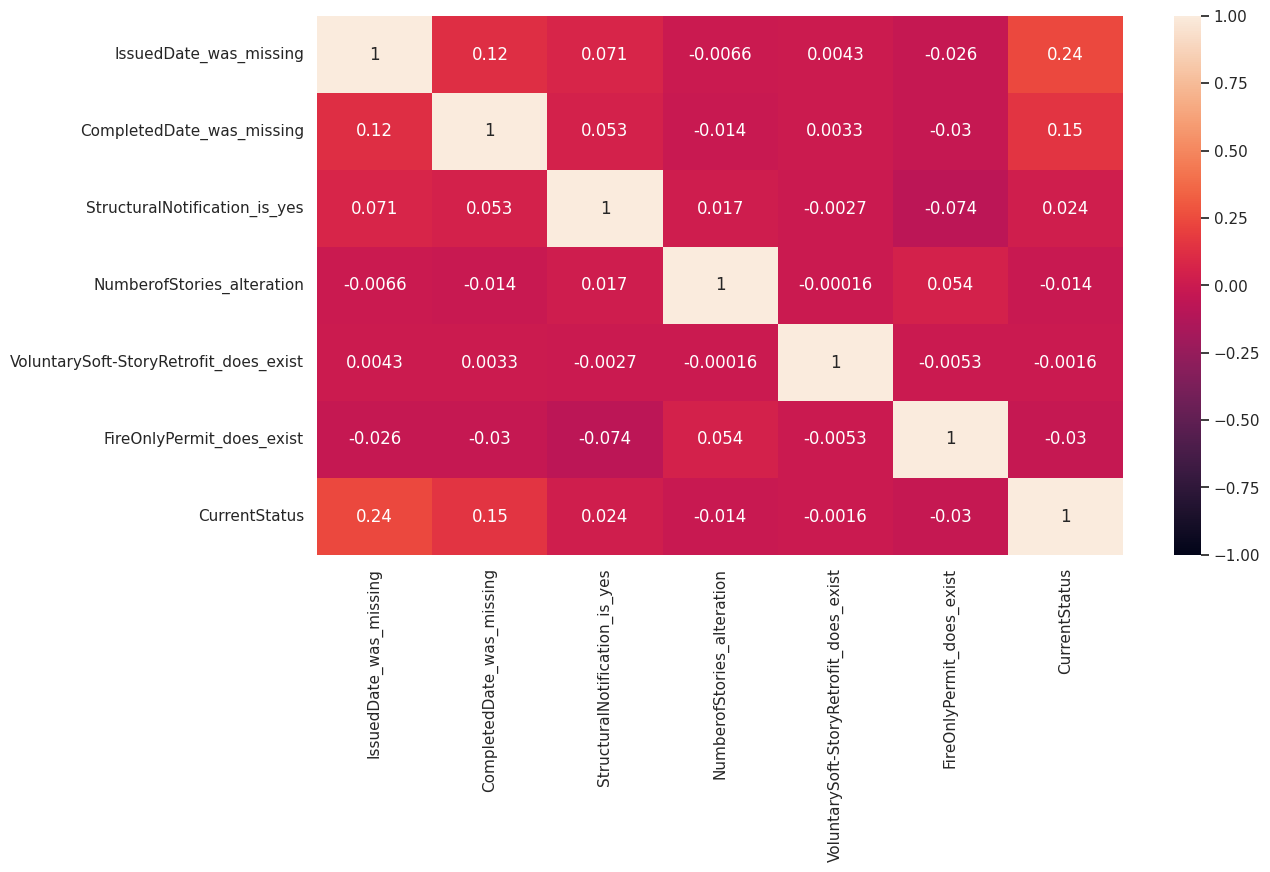

In [329]:
sns.set(rc={'figure.figsize':(13, 7)})

corr_matrix = df1[["IssuedDate_was_missing", 'CompletedDate_was_missing', 'StructuralNotification_is_yes', "NumberofStories_alteration", 'VoluntarySoft-StoryRetrofit_does_exist', 'FireOnlyPermit_does_exist', 'CurrentStatus']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

In [330]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146647 entries, 1 to 198896
Data columns (total 50 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   PermitNumber                            146647 non-null  object 
 1   PermitType                              146647 non-null  int64  
 2   PermitTypeDefinition                    146647 non-null  object 
 3   PermitCreationDate                      146647 non-null  object 
 4   Block                                   146647 non-null  object 
 5   Lot                                     146647 non-null  object 
 6   StreetNumber                            146647 non-null  int64  
 7   StreetNumberSuffix                      1532 non-null    object 
 8   StreetName                              146647 non-null  object 
 9   StreetSuffix                            144545 non-null  object 
 10  Unit                                    2172

In [331]:
a = df.loc[df['RevisedCost'].isnull()].EstimatedCost.unique()
a.sort()
a

array([1.00000e+00, 5.00000e+01, 2.00000e+02, 5.00000e+02, 6.00000e+02,
       8.00000e+02, 9.75000e+02, 1.00000e+03, 1.50000e+03, 2.00000e+03,
       2.10000e+03, 2.29000e+03, 2.37300e+03, 2.40000e+03, 2.50000e+03,
       2.73000e+03, 3.00000e+03, 3.20000e+03, 3.50000e+03, 4.00000e+03,
       4.50000e+03, 4.90000e+03, 5.00000e+03, 6.00000e+03, 6.30000e+03,
       7.00000e+03, 7.50000e+03, 8.00000e+03, 8.60000e+03, 9.00000e+03,
       9.20000e+03, 9.50000e+03, 9.80000e+03, 1.00000e+04, 1.20000e+04,
       1.20600e+04, 1.21180e+04, 1.50000e+04, 1.60000e+04, 1.80000e+04,
       2.00000e+04, 2.50000e+04, 2.60000e+04, 2.75000e+04, 3.00000e+04,
       3.20000e+04, 3.30000e+04, 3.50000e+04, 4.00000e+04, 4.90000e+04,
       5.00000e+04, 5.20000e+04, 6.00000e+04, 6.42250e+04, 6.50000e+04,
       7.00000e+04, 7.50000e+04, 8.00000e+04, 8.50000e+04, 9.00000e+04,
       9.50000e+04, 1.00000e+05, 1.20000e+05, 1.25000e+05, 1.35000e+05,
       1.41841e+05, 1.45000e+05, 1.50000e+05, 1.60000e+05, 1.800

### DF2

Let's fill nans from column RevisedCost with values from EstimatedCost

In [332]:
df2 = df1
df2['RevisedCost'] = df2['RevisedCost'].fillna(df2['EstimatedCost'])

<ipython-input-332-8b6239b28984>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['RevisedCost'] = df2['RevisedCost'].fillna(df2['EstimatedCost'])


<Axes: >

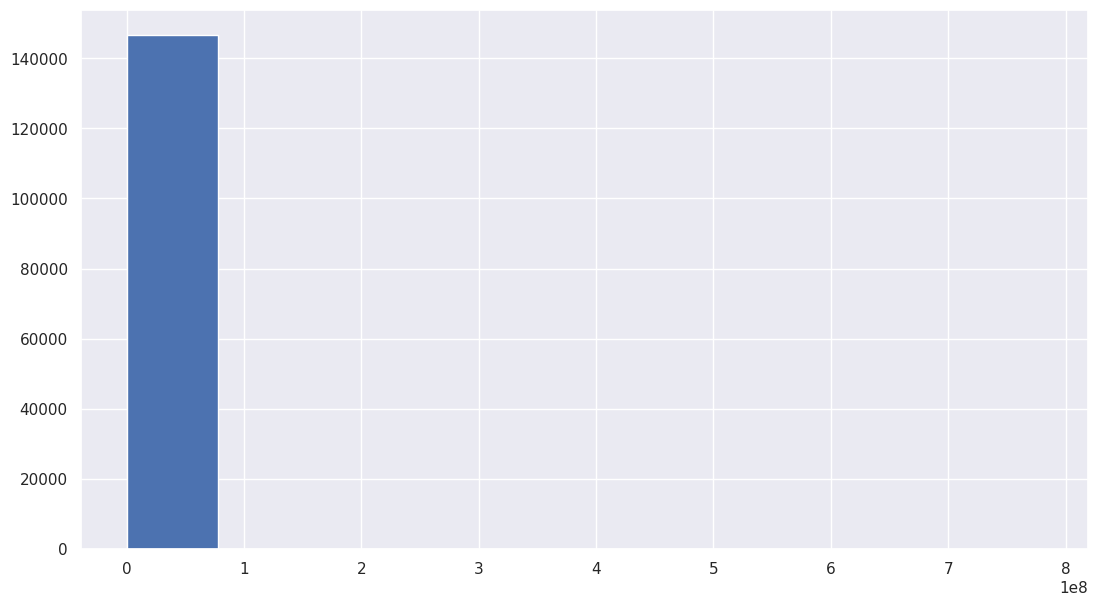

In [333]:
df1['RevisedCost'].hist()

In [334]:
df2['Cost_alteration'] = df2['RevisedCost'] - df2['EstimatedCost']

<ipython-input-334-10df99f11613>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Cost_alteration'] = df2['RevisedCost'] - df2['EstimatedCost']


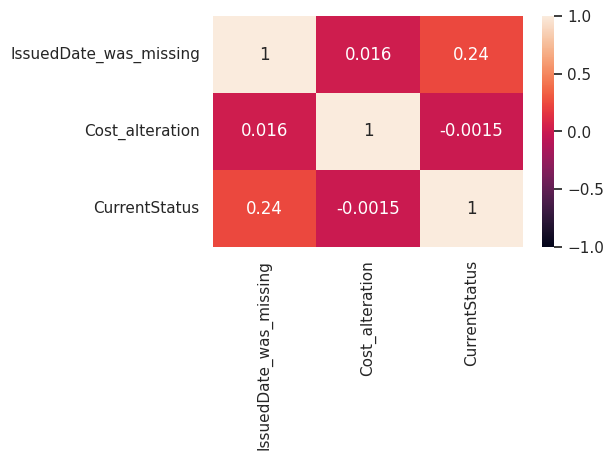

In [335]:
sns.set(rc={'figure.figsize':(5, 3)})

corr_matrix = df2[["IssuedDate_was_missing", 'Cost_alteration', 'CurrentStatus']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

In [336]:
b = df2['ExistingUse'].map(lambda x : (str(x)).lower().strip()).fillna("abacaba")
c = df2['ProposedUse'].map(lambda x : (str(x)).lower().strip()).fillna("abacaba")


In [337]:
df2["Use_was_altered"] = (b != c)

<ipython-input-337-fcdfb6b1bd76>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Use_was_altered"] = (b != c)


In [338]:
df2["Use_was_altered"].value_counts()

False    136671
True       9976
Name: Use_was_altered, dtype: int64

In [339]:
b = list(df2['ExistingUnits'].fillna(0))
b.sort(reverse=True)

In [340]:
df2['ExistingUnits'].value_counts()

1.0      43777
0.0      26839
2.0      20149
3.0       7984
4.0       4995
         ...  
324.0        1
144.0        1
722.0        1
159.0        1
193.0        1
Name: ExistingUnits, Length: 342, dtype: int64

In [341]:
# for Box-Cox Transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

In [342]:
df2['ExistingUnits'].describe()

count    134754.000000
mean         15.859873
std          75.208603
min           0.000000
25%           1.000000
50%           1.000000
75%           4.000000
max        1907.000000
Name: ExistingUnits, dtype: float64

In [343]:
df2['ExistingUnits'] = df2['ExistingUnits'].fillna(method='bfill');

<ipython-input-343-2e6d56599bc3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ExistingUnits'] = df2['ExistingUnits'].fillna(method='bfill');


In [344]:
df2['ProposedUnits'] = df2['ProposedUnits'].fillna(method='bfill');

<ipython-input-344-72ad68732c12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ProposedUnits'] = df2['ProposedUnits'].fillna(method='bfill');


In [345]:
df2['Units_alteration'] = df2['ProposedUnits'] - df2['ExistingUnits'];

<ipython-input-345-670fdfc806f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Units_alteration'] = df2['ProposedUnits'] - df2['ExistingUnits'];


In [346]:
df2.Plansets = df2.Plansets.fillna(method='ffill')

<ipython-input-346-b9e9940d3dae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.Plansets = df2.Plansets.fillna(method='ffill')


In [347]:
df2.loc[df2.TIDFCompliance.notnull()]

,PermitNumber,PermitType,PermitTypeDefinition,PermitCreationDate,Block,Lot,StreetNumber,StreetNumberSuffix,StreetName,StreetSuffix,Unit,UnitSuffix,Description,CurrentStatus,CurrentStatusDate,FiledDate,IssuedDate,CompletedDate,FirstConstructionDocumentDate,StructuralNotification,NumberofExistingStories,NumberofProposedStories,VoluntarySoft-StoryRetrofit,FireOnlyPermit,PermitExpirationDate,EstimatedCost,RevisedCost,ExistingUse,ExistingUnits,ProposedUse,ProposedUnits,Plansets,TIDFCompliance,ExistingConstructionType,ExistingConstructionTypeDescription,ProposedConstructionType,ProposedConstructionTypeDescription,SitePermit,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,Zipcode,Location,RecordID,CompletedDate_was_missing,IssuedDate_was_missing,StructuralNotification_is_yes,NumberofStories_alteration,VoluntarySoft-StoryRetrofit_does_exist,FireOnlyPermit_does_exist,EstimatedCost_was_missing,Cost_alteration,Use_was_altered,Units_alteration
37633,201401287280,3,additions alterations or repairs,01/28/2014,3508,001,1355,NaN,Market,St,NaN,NaN,ground floor interior remodel to include selec...,0,02/06/2015,01/28/2014,11/19/2014,02/06/2015,11/19/2014,N,11.0,11.0,NaN,NaN,11/03/2017,1200000.0,1200000.0,retail sales,0.0,retail sales,0.0,2.0,Y,1.0,constr type 1,1.0,constr type 1,NaN,6.0,South of Market,94103.0,"(37.77674230325018, -122.41635986037679)",1331051347127,False,False,False,0.0,False,False,False,0.0,False,0.0
101903,201510139437,3,additions alterations or repairs,10/13/2015,3612,071,3221,NaN,20th,St,NaN,NaN,rev. to 201306280716 -for planning dept pupose...,0,03/23/2016,10/13/2015,03/16/2016,03/23/2016,03/16/2016,N,3.0,3.0,NaN,NaN,03/11/2017,1.0,1.0,office,0.0,office,0.0,2.0,P,5.0,wood frame (5),5.0,wood frame (5),NaN,9.0,Mission,94110.0,"(37.75877829596645, -122.41301215182484)",1398961162071,False,False,False,0.0,False,False,False,0.0,False,0.0


In [348]:
df2.loc[df2.ExistingConstructionTypeDescription.notnull()].CurrentStatus.value_counts()

0    140506
1      1712
Name: CurrentStatus, dtype: int64

In [349]:
df2.ExistingConstructionTypeDescription = df2.ExistingConstructionTypeDescription.fillna(method='bfill')

<ipython-input-349-2efd06242c09>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.ExistingConstructionTypeDescription = df2.ExistingConstructionTypeDescription.fillna(method='bfill')


In [350]:
df2.ProposedConstructionTypeDescription = df2.ProposedConstructionTypeDescription.fillna(method='bfill')

<ipython-input-350-a61aedc57e66>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.ProposedConstructionTypeDescription = df2.ProposedConstructionTypeDescription.fillna(method='bfill')


In [351]:
df2['ConstructionType_is_altered'] = df2.ProposedConstructionTypeDescription != df2.ExistingConstructionTypeDescription

<ipython-input-351-4888840a0069>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ConstructionType_is_altered'] = df2.ProposedConstructionTypeDescription != df2.ExistingConstructionTypeDescription


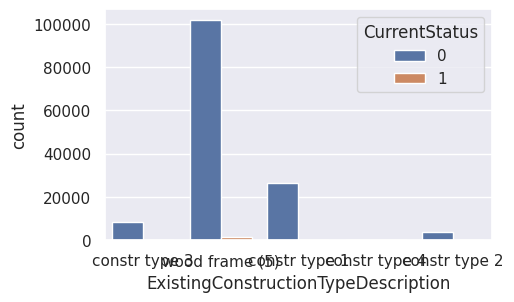

In [352]:
sns.countplot(x="ExistingConstructionTypeDescription", hue="CurrentStatus", data=df);

In [353]:
df2.loc[~df2.SitePermit.isnull()].CurrentStatus.value_counts()

0    3316
1     122
Name: CurrentStatus, dtype: int64

In [354]:
df2.SitePermit = df2.SitePermit.fillna('N')

<ipython-input-354-585fcab039d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.SitePermit = df2.SitePermit.fillna('N')


In [355]:
df2.SitePermit = df2.SitePermit.map({'Y': True, 'N': False}).astype(bool)

<ipython-input-355-82af587f0922>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.SitePermit = df2.SitePermit.map({'Y': True, 'N': False}).astype(bool)


In [356]:
df2[['SupervisorDistrict']].sample(60)

,SupervisorDistrict
64599,8.0
14276,2.0
133526,9.0
128371,2.0
20109,6.0
156342,9.0
19181,11.0
22012,8.0
44739,7.0
76473,8.0


In [357]:
df2 = df2[df2['SupervisorDistrict'].notna()]

In [358]:
df2[['Neighborhoods-AnalysisBoundaries']].value_counts()

Neighborhoods-AnalysisBoundaries
Financial District/South Beach      19022
Mission                              9949
Sunset/Parkside                      8465
West of Twin Peaks                   7215
Castro/Upper Market                  5891
South of Market                      5770
Outer Richmond                       5656
Noe Valley                           5528
Marina                               5491
Pacific Heights                      5239
Bernal Heights                       4480
Bayview Hunters Point                4376
Inner Sunset                         4291
Haight Ashbury                       3846
Nob Hill                             3823
Hayes Valley                         3644
Tenderloin                           3561
Russian Hill                         3547
Potrero Hill                         3106
Inner Richmond                       3012
Western Addition                     2942
Chinatown                            2809
North Beach                          2783
P

In [359]:
df2 = df2[df2['Neighborhoods-AnalysisBoundaries'].notna()]

In [360]:
df2 = df2[df2['Zipcode'].notna()]

In [361]:
df2[['Location']]

,Location
1,"(37.78733980600732, -122.41063199757738)"
3,"(37.79595867909168, -122.41557405519474)"
4,"(37.78315261897309, -122.40950883997789)"
5,"(37.75922331346539, -122.39170402628598)"
6,"(37.764145640138565, -122.46875112470363)"
...,...
198873,"(37.73708421334594, -122.4157759256698)"
198874,"(37.746231746880696, -122.4285179313817)"
198877,"(37.7146765393289, -122.45557353560899)"
198879,"(37.72324934238285, -122.43409219261636)"


In [362]:
def coord1_parse(line):
    return [float(bit.rstrip(',')) for bit in line[1:-1].split()][0]

def coord2_parse(line):
    return [float(bit.rstrip(',')) for bit in line[1:-1].split()][1]

In [363]:
df2['Latitude'] = df2.Location.map(coord1_parse)
df2['Longitude'] = df2.Location.map(coord2_parse)

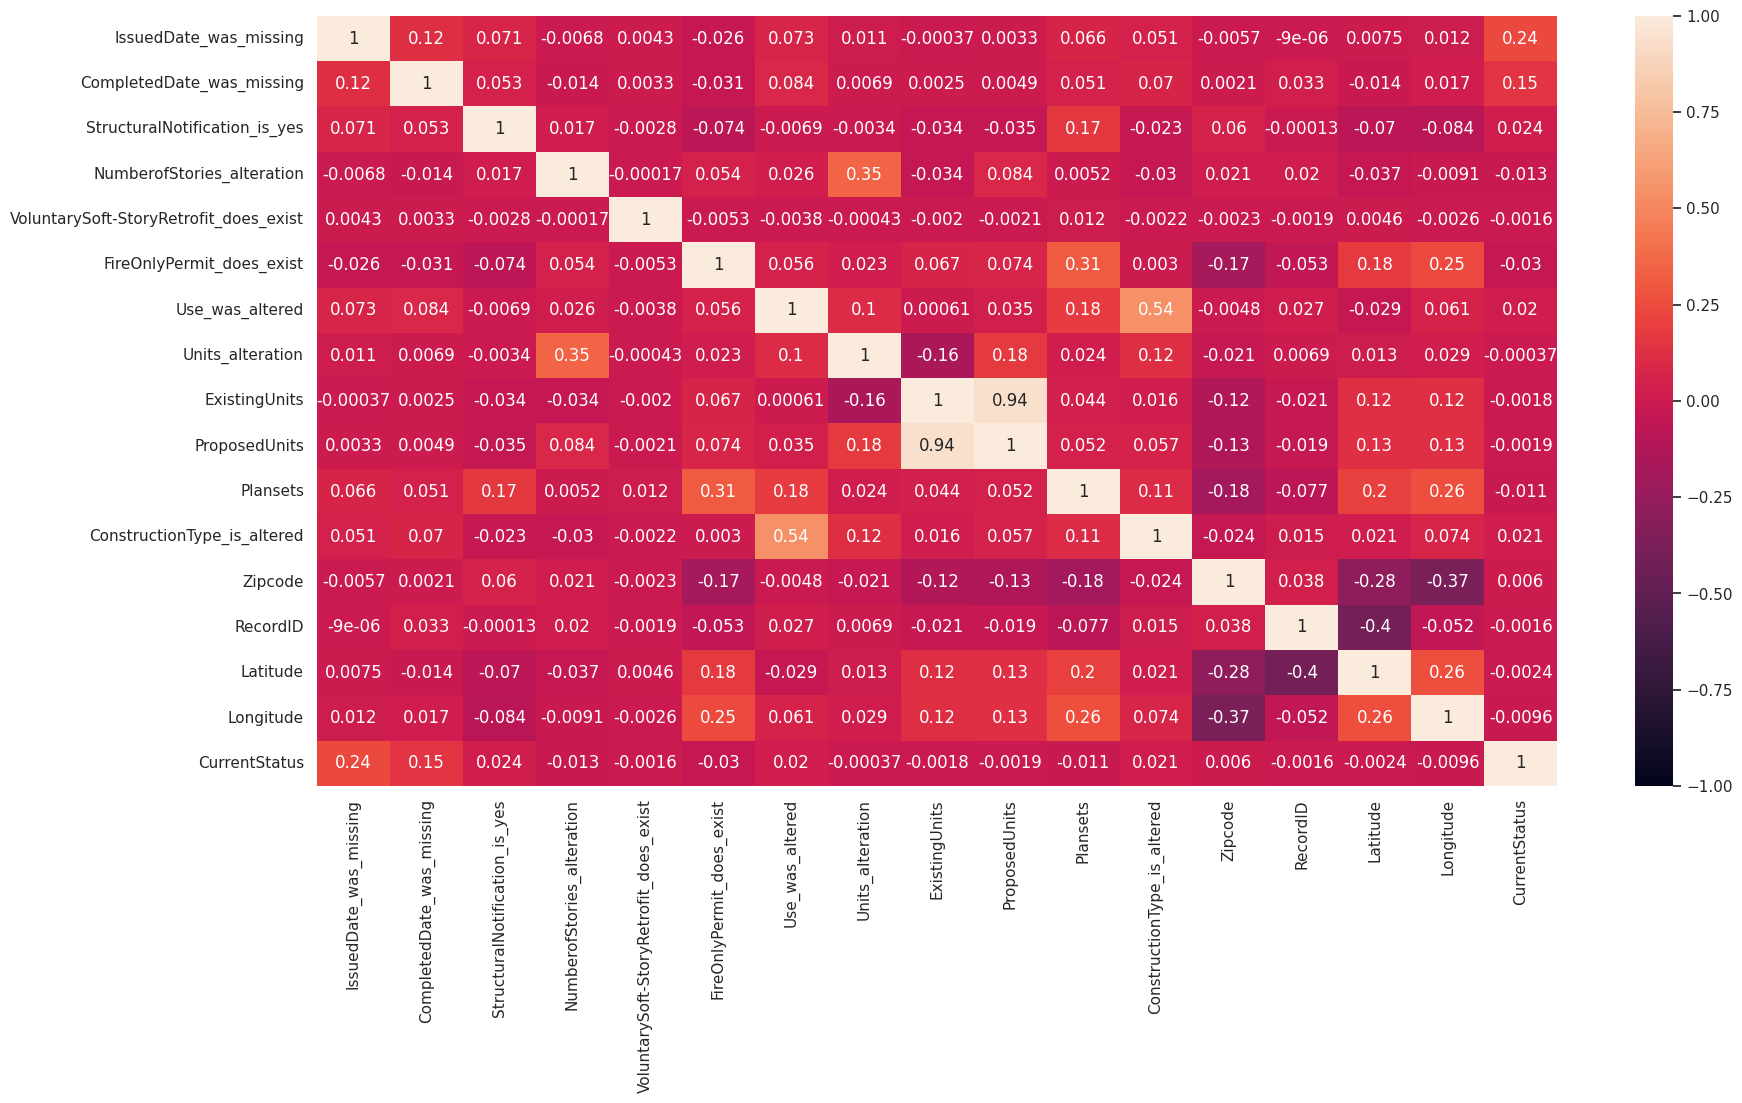

In [364]:
sns.set(rc={'figure.figsize':(20, 10)})

corr_matrix = df2[["IssuedDate_was_missing", 'CompletedDate_was_missing', 'StructuralNotification_is_yes',
                   "NumberofStories_alteration", 'VoluntarySoft-StoryRetrofit_does_exist', 'FireOnlyPermit_does_exist',
                   'Use_was_altered', 'Units_alteration', 'ExistingUnits', 'ProposedUnits', 'Plansets', 'ConstructionType_is_altered',
                   'Zipcode', 'RecordID', 'Latitude', 'Longitude', 'CurrentStatus']].corr()
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True);

In [365]:
df2[['NumberofExistingStories']].loc[df2.NumberofExistingStories.isnull()]

,NumberofExistingStories
90,NaN
99,NaN
118,NaN
152,NaN
193,NaN
...,...
197905,NaN
197907,NaN
198809,NaN
198810,NaN


In [366]:
df2['NumberofExistingStories'] = df2['NumberofExistingStories'].fillna(method='bfill')
df2['NumberofProposedStories'] = df2['NumberofProposedStories'].fillna(method='bfill') 

In [367]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145586 entries, 1 to 198882
Data columns (total 56 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   PermitNumber                            145586 non-null  object 
 1   PermitType                              145586 non-null  int64  
 2   PermitTypeDefinition                    145586 non-null  object 
 3   PermitCreationDate                      145586 non-null  object 
 4   Block                                   145586 non-null  object 
 5   Lot                                     145586 non-null  object 
 6   StreetNumber                            145586 non-null  int64  
 7   StreetNumberSuffix                      1511 non-null    object 
 8   StreetName                              145586 non-null  object 
 9   StreetSuffix                            143508 non-null  object 
 10  Unit                                    2167

### DF_CLEAN

to delete: StreetNumberSuffix, Unit, UnitSuffix, CompletedDate (added binary feature), FirstConstructionDocumentDate (because of correlation), StructuralNotification (binary feature added), VoluntarySoft-StoryRetrofit (binary feature added), ExistingUse, ProposedUse, TIDFCompliance, ProposedConstructionType, ExistingConstructionType, RecordID

In [368]:
df_clean = df2.drop(['StreetNumberSuffix', 'Unit', 'UnitSuffix', 'CompletedDate',
                     'FirstConstructionDocumentDate', 'StructuralNotification',
                     'VoluntarySoft-StoryRetrofit', 'ExistingUse', 'ProposedUse',
                     'TIDFCompliance', 'ProposedConstructionType', 'ExistingConstructionType', 'FireOnlyPermit', 'RecordID'], axis=1)

In [369]:
description_col = df_clean.Description
issueddate_col = df_clean.IssuedDate
PermitExpirationDate_col = df_clean.PermitExpirationDate
df_clean.drop(['Description', 'IssuedDate', 'PermitExpirationDate'], axis=1, inplace=True)

In [370]:
df_clean.drop(['PermitNumber', 'PermitTypeDefinition', 'Location'], axis=1, inplace=True)

In [371]:
df_clean.drop(['PermitCreationDate'], axis=1, inplace=True)

In [372]:
df_clean.StreetSuffix = df_clean.StreetSuffix.fillna(method='bfill')

In [373]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145586 entries, 1 to 198882
Data columns (total 35 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   PermitType                              145586 non-null  int64  
 1   Block                                   145586 non-null  object 
 2   Lot                                     145586 non-null  object 
 3   StreetNumber                            145586 non-null  int64  
 4   StreetName                              145586 non-null  object 
 5   StreetSuffix                            145586 non-null  object 
 6   CurrentStatus                           145586 non-null  int64  
 7   CurrentStatusDate                       145586 non-null  object 
 8   FiledDate                               145586 non-null  object 
 9   NumberofExistingStories                 145586 non-null  float64
 10  NumberofProposedStories                 1455

In [374]:
df_clean.head(10)

,PermitType,Block,Lot,StreetNumber,StreetName,StreetSuffix,CurrentStatus,CurrentStatusDate,FiledDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUnits,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SitePermit,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,Zipcode,CompletedDate_was_missing,IssuedDate_was_missing,StructuralNotification_is_yes,NumberofStories_alteration,VoluntarySoft-StoryRetrofit_does_exist,FireOnlyPermit_does_exist,EstimatedCost_was_missing,Cost_alteration,Use_was_altered,Units_alteration,ConstructionType_is_altered,Latitude,Longitude
1,4,0306,007,440,Geary,St,0,08/03/2017,04/19/2016,7.0,2.0,1.0,500.0,1.0,1.0,2.0,constr type 3,wood frame (5),False,3.0,Tenderloin,94102.0,True,False,False,-7.0,False,False,False,499.0,True,0.0,True,37.787340,-122.410632
3,8,0156,011,1230,Pacific,Av,0,07/24/2017,11/07/2016,2.0,2.0,2000.0,2000.0,1.0,1.0,2.0,wood frame (5),wood frame (5),False,3.0,Nob Hill,94109.0,False,False,False,0.0,False,False,False,0.0,False,0.0,False,37.795959,-122.415574
4,6,0342,001,950,Market,St,0,12/01/2017,11/28/2016,3.0,5.0,100000.0,100000.0,326.0,326.0,2.0,constr type 3,constr type 1,False,6.0,Tenderloin,94102.0,True,False,False,-3.0,False,False,False,0.0,True,0.0,True,37.783153,-122.409509
5,8,4105,009,800,Indiana,St,0,07/06/2017,06/14/2017,5.0,5.0,4000.0,4000.0,326.0,326.0,2.0,constr type 1,constr type 1,False,10.0,Potrero Hill,94107.0,True,False,False,0.0,False,True,False,0.0,False,0.0,False,37.759223,-122.391704
6,8,1739,020,1291,11th,Av,0,07/12/2017,06/30/2017,3.0,3.0,12000.0,12000.0,5.0,5.0,0.0,wood frame (5),wood frame (5),False,5.0,Inner Sunset,94122.0,False,False,False,0.0,False,False,False,0.0,False,0.0,False,37.764146,-122.468751
24,8,0542,039,1,Charlton,Ct,0,08/08/2017,08/08/2017,4.0,4.0,64650.0,64650.0,9.0,9.0,0.0,wood frame (5),wood frame (5),False,2.0,Marina,94123.0,True,False,False,0.0,False,False,False,0.0,False,0.0,False,37.797391,-122.431271
25,8,1824,006,1435,29th,Av,0,08/16/2017,08/16/2017,2.0,2.0,7000.0,7000.0,1.0,1.0,0.0,wood frame (5),wood frame (5),False,4.0,Sunset/Parkside,94122.0,True,False,False,0.0,False,False,False,0.0,False,0.0,False,37.760523,-122.487989
33,3,3749,047,76,Lansing,St,0,12/14/2017,08/24/2017,3.0,3.0,73000.0,73000.0,6.0,6.0,2.0,wood frame (5),wood frame (5),False,6.0,Financial District/South Beach,94105.0,True,True,False,0.0,False,False,False,0.0,False,0.0,False,37.785954,-122.394441
48,8,5934,020,938,Felton,St,0,10/31/2017,10/11/2017,2.0,2.0,14000.0,14000.0,1.0,1.0,0.0,wood frame (5),wood frame (5),False,9.0,Portola,94134.0,False,False,False,0.0,False,False,False,0.0,False,0.0,False,37.727755,-122.414192
68,8,1744,039,1241,06th,Av,0,11/27/2017,11/27/2017,2.0,2.0,6000.0,6000.0,3.0,3.0,0.0,wood frame (5),wood frame (5),False,5.0,Inner Sunset,94122.0,True,False,False,0.0,False,False,False,0.0,False,0.0,False,37.765358,-122.463470


In [375]:
df_clean.Plansets.value_counts()

2.0    84041
0.0    61292
3.0      247
4.0        3
6.0        2
1.0        1
Name: Plansets, dtype: int64

In [376]:
df_clean.drop(df_clean[(df_clean.Plansets == 4) | (df_clean.Plansets == 6) | (df_clean.Plansets == 1)].index, inplace=True)

In [377]:
df_clean.SupervisorDistrict = df_clean.SupervisorDistrict.astype(int)
df_clean.Zipcode = df_clean.Zipcode.astype(int)
df_clean.Plansets = df_clean.Plansets.astype(int)

## Setting additional information about dataset

In [378]:
df_clean.sample(5)

,PermitType,Block,Lot,StreetNumber,StreetName,StreetSuffix,CurrentStatus,CurrentStatusDate,FiledDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUnits,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SitePermit,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,Zipcode,CompletedDate_was_missing,IssuedDate_was_missing,StructuralNotification_is_yes,NumberofStories_alteration,VoluntarySoft-StoryRetrofit_does_exist,FireOnlyPermit_does_exist,EstimatedCost_was_missing,Cost_alteration,Use_was_altered,Units_alteration,ConstructionType_is_altered,Latitude,Longitude
82037,8,1537,053,402,08th,Av,0,10/29/2015,04/10/2015,4.0,4.0,1.0,1.0,14.0,14.0,2,wood frame (5),wood frame (5),False,1,Inner Richmond,94118,False,False,False,0.0,False,False,False,0.0,True,0.0,False,37.780630,-122.466052
18452,8,0959,006,2611,Divisadero,St,0,02/28/2014,07/12/2013,3.0,3.0,20000.0,20000.0,1.0,1.0,0,wood frame (5),wood frame (5),False,2,Pacific Heights,94123,False,False,False,0.0,False,False,False,0.0,False,0.0,False,37.793850,-122.441837
172993,3,0872,008,34,Buchanan,St,0,02/01/2018,05/18/2016,3.0,3.0,50000.0,61000.0,12.0,12.0,2,wood frame (5),wood frame (5),False,8,Hayes Valley,94102,False,False,False,0.0,False,False,False,11000.0,False,0.0,False,37.770159,-122.426357
2687,8,0668,013,1461,Pine,St,0,01/02/2014,01/28/2013,5.0,5.0,20000.0,30000.0,35.0,35.0,2,constr type 1,constr type 1,False,3,Nob Hill,94109,False,False,False,0.0,False,True,False,10000.0,False,0.0,False,37.789466,-122.419685
167946,8,3605,016,3636,21st,St,0,08/09/2017,08/09/2017,3.0,3.0,30000.0,30000.0,1.0,1.0,2,wood frame (5),wood frame (5),False,8,Castro/Upper Market,94114,True,False,False,0.0,False,False,False,0.0,False,0.0,False,37.756682,-122.428814


In [379]:
num_cols = [
    'NumberofExistingStories',
    'NumberofProposedStories',
    'EstimatedCost',
    'RevisedCost',
    'ExistingUnits',
    'ProposedUnits',
    'NumberofStories_alteration',
    'Cost_alteration',
    'Units_alteration',
    'Latitude',
    'Longitude',
]

cat_cols = [
    'PermitType',
    'StreetSuffix',
    'ExistingConstructionTypeDescription',
    'ProposedConstructionTypeDescription',
    'SitePermit',
    'SupervisorDistrict',
    'Neighborhoods-AnalysisBoundaries',
    'Zipcode',
    'CompletedDate_was_missing',
    'IssuedDate_was_missing',
    'StructuralNotification_is_yes',
    'VoluntarySoft-StoryRetrofit_does_exist',
    'FireOnlyPermit_does_exist',
    'EstimatedCost_was_missing',
    'Use_was_altered',
    'ConstructionType_is_altered', 
    'Plansets',
]

idk_how_to_use_it_cols = [
    'Block',
    'Lot',
    'StreetNumber',
    'StreetName',
]

target = 'CurrentStatus'

In [380]:
df_clean.head()

,PermitType,Block,Lot,StreetNumber,StreetName,StreetSuffix,CurrentStatus,CurrentStatusDate,FiledDate,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUnits,ProposedUnits,Plansets,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SitePermit,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,Zipcode,CompletedDate_was_missing,IssuedDate_was_missing,StructuralNotification_is_yes,NumberofStories_alteration,VoluntarySoft-StoryRetrofit_does_exist,FireOnlyPermit_does_exist,EstimatedCost_was_missing,Cost_alteration,Use_was_altered,Units_alteration,ConstructionType_is_altered,Latitude,Longitude
1,4,0306,007,440,Geary,St,0,08/03/2017,04/19/2016,7.0,2.0,1.0,500.0,1.0,1.0,2,constr type 3,wood frame (5),False,3,Tenderloin,94102,True,False,False,-7.0,False,False,False,499.0,True,0.0,True,37.787340,-122.410632
3,8,0156,011,1230,Pacific,Av,0,07/24/2017,11/07/2016,2.0,2.0,2000.0,2000.0,1.0,1.0,2,wood frame (5),wood frame (5),False,3,Nob Hill,94109,False,False,False,0.0,False,False,False,0.0,False,0.0,False,37.795959,-122.415574
4,6,0342,001,950,Market,St,0,12/01/2017,11/28/2016,3.0,5.0,100000.0,100000.0,326.0,326.0,2,constr type 3,constr type 1,False,6,Tenderloin,94102,True,False,False,-3.0,False,False,False,0.0,True,0.0,True,37.783153,-122.409509
5,8,4105,009,800,Indiana,St,0,07/06/2017,06/14/2017,5.0,5.0,4000.0,4000.0,326.0,326.0,2,constr type 1,constr type 1,False,10,Potrero Hill,94107,True,False,False,0.0,False,True,False,0.0,False,0.0,False,37.759223,-122.391704
6,8,1739,020,1291,11th,Av,0,07/12/2017,06/30/2017,3.0,3.0,12000.0,12000.0,5.0,5.0,0,wood frame (5),wood frame (5),False,5,Inner Sunset,94122,False,False,False,0.0,False,False,False,0.0,False,0.0,False,37.764146,-122.468751


## another preprocessing (num and cat features)

In [381]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [382]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

from catboost import CatBoostClassifier, Pool, metrics, cv

In [383]:
X_train, X_test, y_train, y_test = train_test_split(df_clean[num_cols + cat_cols], df_clean[target], test_size=0.3)

In [384]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((101906, 28), (43674, 28), (101906,), (43674,))

In [385]:
pca1 = StandardScaler()
pca2 = StandardScaler()
X_train_scaled = X_train
X_test_scaled = X_test

X_train_scaled[num_cols] = pca1.fit_transform(X_train_scaled[num_cols])
X_test_scaled[num_cols] = pca2.fit_transform(X_test_scaled[num_cols])

In [386]:
def get_scores(clf, X, y, threshold_start, threshold_end, threshold_step):
    ra = roc_auc_score(y, (clf.predict_proba(X)[:,1]))
    print(f'Basic roc-auc = {ra * 100:.3f}%')
    print()

    for threshold in np.arange(threshold_start, threshold_end, threshold_step):
        aucScore       = roc_auc_score(y, (clf.predict_proba(X)[:,1] >= threshold).astype(bool))
        recallScore    = recall_score(y, (clf.predict_proba(X)[:,1] >= threshold).astype(bool))
        precisionScore = precision_score(y, (clf.predict_proba(X)[:,1] >= threshold).astype(bool))
        f1Score        = f1_score(y, (clf.predict_proba(X)[:,1] >= threshold).astype(bool))

        print(f'threshold = {threshold:.3f}:')
        print(f'    roc-auc = {aucScore * 100:.3f}%')
        print(f'    recall = {recallScore * 100:.3f}%')
        print(f'    precision = {precisionScore * 100:.3f}%')
        print(f'    f1 = {f1Score * 100:.3f}%')
        print()

### preprocessing -- categorical features

#### too much unique values => not one hot encoding

In [387]:
def replace_by_other(a, d, boundary):
    if (d[a] < boundary):
        return 'other'
    else:
        return a

In [388]:
X_train_scaled.StreetSuffix.value_counts().loc[X_train_scaled.StreetSuffix.value_counts() < 1000].sum()

2360

In [389]:
X_test_scaled.StreetSuffix.value_counts(), X_train_scaled.StreetSuffix.value_counts()

(St    30193
 Av     9925
 Wy      883
 Dr      853
 Bl      823
 Tr      351
 Ct      179
 Pl      106
 Rd       92
 Ln       76
 Pz       56
 Hy       51
 Pk       33
 Cr       29
 Al       15
 Wk        4
 Rw        2
 So        2
 No        1
 Name: StreetSuffix, dtype: int64,
 St    70512
 Av    23152
 Wy     2129
 Dr     1919
 Bl     1834
 Tr      785
 Ct      422
 Pl      283
 Ln      217
 Rd      205
 Hy      140
 Pz      137
 Pk       61
 Cr       53
 Al       46
 Wk        6
 Rw        2
 Hl        1
 Sw        1
 No        1
 Name: StreetSuffix, dtype: int64)

In [390]:
X_train_scaled.StreetSuffix.value_counts().loc[X_train_scaled.StreetSuffix.value_counts() < 1000].sum(), X_test_scaled.StreetSuffix.value_counts().loc[X_test_scaled.StreetSuffix.value_counts() < 500].sum()

(2360, 997)

In [391]:
X_train_scaled_cat = X_train_scaled
d1_train = X_train_scaled.StreetSuffix.value_counts()
X_train_scaled_cat.StreetSuffix = X_train_scaled.StreetSuffix.map(lambda x : replace_by_other(x, d1_train, 1000))

X_test_scaled_cat = X_test_scaled
d1_test = X_test_scaled.StreetSuffix.value_counts()
X_test_scaled_cat.StreetSuffix = X_test_scaled.StreetSuffix.map(lambda x : replace_by_other(x, d1_test, 500))

In [392]:
X_test_scaled_cat.PermitType.value_counts(), X_train_scaled_cat.PermitType.value_counts()

(8    39216
 3     3152
 4      748
 2      208
 6      129
 7      124
 1       72
 5       25
 Name: PermitType, dtype: int64,
 8    92025
 3     7051
 4     1683
 2      423
 6      292
 7      254
 1      119
 5       59
 Name: PermitType, dtype: int64)

In [393]:
X_train_scaled_cat['Neighborhoods-AnalysisBoundaries'].value_counts()

Financial District/South Beach    13261
Mission                            6972
Sunset/Parkside                    5922
West of Twin Peaks                 5006
Castro/Upper Market                4118
South of Market                    4031
Outer Richmond                     3999
Marina                             3922
Noe Valley                         3858
Pacific Heights                    3722
Bernal Heights                     3100
Inner Sunset                       3033
Bayview Hunters Point              2979
Haight Ashbury                     2730
Nob Hill                           2718
Hayes Valley                       2541
Russian Hill                       2516
Tenderloin                         2472
Potrero Hill                       2152
Inner Richmond                     2082
Western Addition                   2042
Chinatown                          1976
North Beach                        1972
Presidio Heights                   1860
Excelsior                          1715


In [394]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [395]:
from category_encoders import TargetEncoder

In [396]:
tgt_enc1 = TargetEncoder()
tgt_enc2 = TargetEncoder()
X_train_scaled_cat['Neighborhoods-AnalysisBoundaries'] = tgt_enc1.fit_transform(X_train_scaled_cat['Neighborhoods-AnalysisBoundaries'], y_train)
X_test_scaled_cat['Neighborhoods-AnalysisBoundaries'] = tgt_enc2.fit_transform(X_test_scaled_cat['Neighborhoods-AnalysisBoundaries'], y_test)

In [397]:
X_train_scaled_cat['Zipcode'] = X_train_scaled_cat['Zipcode'].astype('O')
X_test_scaled_cat['Zipcode']  = X_test_scaled_cat['Zipcode'].astype('O')

X_train_scaled_cat['Zipcode'] = tgt_enc1.fit_transform(X_train_scaled_cat['Zipcode'], y_train)
X_test_scaled_cat['Zipcode'] = tgt_enc2.fit_transform(X_test_scaled_cat['Zipcode'], y_test)

In [398]:
X_train_scaled_cat.PermitType.value_counts(), X_test_scaled_cat.PermitType.value_counts()

(8    92025
 3     7051
 4     1683
 2      423
 6      292
 7      254
 1      119
 5       59
 Name: PermitType, dtype: int64,
 8    39216
 3     3152
 4      748
 2      208
 6      129
 7      124
 1       72
 5       25
 Name: PermitType, dtype: int64)

In [399]:
X_train_scaled_cat.PermitType.value_counts().loc[X_train_scaled_cat.PermitType.value_counts() < 1000].sum(), X_test_scaled_cat.PermitType.value_counts().loc[X_test_scaled_cat.PermitType.value_counts() < 500].sum()

(1147, 558)

In [400]:
d_train = X_train_scaled_cat.PermitType.value_counts()
d_test = X_test_scaled_cat.PermitType.value_counts()

In [401]:
X_train_scaled_cat.PermitType = X_train_scaled_cat.PermitType.map(lambda x : replace_by_other(x, d_train, 1000))
X_test_scaled_cat.PermitType = X_test_scaled_cat.PermitType.map(lambda x : replace_by_other(x, d_test, 500))

In [402]:
X_train_scaled_cat.SupervisorDistrict.value_counts()

3     15107
6     13963
8     13090
2     11755
5      9215
7      8340
9      8210
1      6491
10     6306
4      5544
11     3885
Name: SupervisorDistrict, dtype: int64

In [403]:
X_test_scaled_cat.SupervisorDistrict.value_counts()

3     6465
6     6021
8     5646
2     4823
5     3893
7     3616
9     3500
10    2855
1     2768
4     2367
11    1720
Name: SupervisorDistrict, dtype: int64

In [404]:
num_cols_after_cat = [
    'NumberofExistingStories',
    'NumberofProposedStories',
    'EstimatedCost',
    'RevisedCost',
    'ExistingUnits',
    'ProposedUnits',
    'NumberofStories_alteration',
    'Cost_alteration',
    'Units_alteration',
    'Latitude',
    'Longitude',
    'Neighborhoods-AnalysisBoundaries',
    'Zipcode',
]

#### one hot encoding 

In [405]:
cols_to_ohe = ['PermitType', 'StreetSuffix', 'ExistingConstructionTypeDescription', 'ProposedConstructionTypeDescription', 'SupervisorDistrict', 'Plansets']
X_train_scaled_cat_ohe = pd.get_dummies(X_train_scaled_cat, columns=cols_to_ohe)
X_test_scaled_cat_ohe = pd.get_dummies(X_test_scaled_cat, columns=cols_to_ohe)

In [406]:
X_train_scaled_cat_ohe.replace({False: 0, True: 1}, inplace=True)
X_test_scaled_cat_ohe.replace({False: 0, True: 1}, inplace=True)

# Baseline

## CatBoost

In [ ]:
X_test.head()

,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUnits,ProposedUnits,NumberofStories_alteration,Cost_alteration,Units_alteration,Latitude,Longitude,PermitType,StreetSuffix,ExistingConstructionTypeDescription,ProposedConstructionTypeDescription,SitePermit,SupervisorDistrict,Neighborhoods-AnalysisBoundaries,Zipcode,CompletedDate_was_missing,IssuedDate_was_missing,StructuralNotification_is_yes,VoluntarySoft-StoryRetrofit_does_exist,FireOnlyPermit_does_exist,EstimatedCost_was_missing,Use_was_altered,ConstructionType_is_altered,Plansets
56409,-0.433365,0.017047,-0.041388,-0.044726,-0.207786,4.931195,2.818212,-0.030410,16.379586,-0.039174,1.194338,8,St,wood frame (5),constr type 3,False,10,Mission Bay,94107,False,False,False,False,True,False,True,True,2
69584,0.252354,0.244776,-0.043495,-0.046143,0.932810,0.923091,-0.020049,-0.027413,-0.028276,1.280850,1.060512,8,St,constr type 1,constr type 1,False,3,Financial District/South Beach,94111,False,False,False,False,False,False,False,False,2
166264,-0.319079,-0.324547,-0.017913,-0.023469,0.080641,0.071696,-0.020049,-0.034909,-0.028276,1.288078,0.355876,8,St,wood frame (5),wood frame (5),False,2,Russian Hill,94109,True,False,False,False,False,False,False,False,2
190627,0.138067,0.130911,-0.043495,-0.047560,-0.194676,-0.203369,-0.020049,-0.034909,-0.028276,0.231589,1.070353,8,St,constr type 1,constr type 1,False,6,South of Market,94103,True,False,False,False,False,False,False,False,2
66494,-0.433365,-0.438411,-0.040485,-0.044726,-0.194676,-0.203369,-0.020049,-0.034909,-0.028276,-2.095395,1.214969,8,Av,wood frame (5),wood frame (5),False,10,Bayview Hunters Point,94124,False,False,False,False,False,False,False,False,0


In [ ]:
X_valid_cbc, X_test_cbc, y_valid_cbc, y_test_cbc = train_test_split(X_test_scaled, y_test, test_size=0.5)

In [ ]:
params = {
    'loss_function' : 'Logloss',
    'eval_metric' : 'AUC',
    'verbose' : 200,
    'random_seed' : 42,
    'custom_metric' : 'AUC:hints=skip_train~false'
}

cbc = CatBoostClassifier(**params)
cbc.fit(X_train_scaled, y_train,
        cat_features=cat_cols,
        eval_set = (X_valid_cbc, y_valid_cbc),
        use_best_model = True
);

Learning rate set to 0.102626
0:	learn: 0.5510743	test: 0.5607449	best: 0.5607449 (0)	total: 342ms	remaining: 5m 42s
200:	learn: 0.9325036	test: 0.8976165	best: 0.8995401 (141)	total: 1m 5s	remaining: 4m 20s
400:	learn: 0.9468251	test: 0.8954598	best: 0.8995401 (141)	total: 2m 2s	remaining: 3m 2s
600:	learn: 0.9572907	test: 0.8955276	best: 0.8995401 (141)	total: 3m 1s	remaining: 2m
800:	learn: 0.9661477	test: 0.8980269	best: 0.8995401 (141)	total: 3m 57s	remaining: 59s
999:	learn: 0.9718919	test: 0.8984620	best: 0.8995401 (141)	total: 4m 54s	remaining: 0us

bestTest = 0.8995400725
bestIteration = 141

Shrink model to first 142 iterations.


In [ ]:
get_scores(cbc, X_test_cbc, y_test_cbc, 0.01, 0.1, 0.01)

threshold = 0.010:
    roc-auc = 84.262%
    recall = 99.412%
    precision = 3.664%
    f1 = 7.067%

threshold = 0.020:
    roc-auc = 84.557%
    recall = 91.765%
    precision = 4.568%
    f1 = 8.703%

threshold = 0.030:
    roc-auc = 81.760%
    recall = 80.000%
    precision = 5.425%
    f1 = 10.161%

threshold = 0.040:
    roc-auc = 74.696%
    recall = 60.588%
    precision = 6.009%
    f1 = 10.934%

threshold = 0.050:
    roc-auc = 67.475%
    recall = 39.412%
    precision = 9.450%
    f1 = 15.245%

threshold = 0.060:
    roc-auc = 63.772%
    recall = 28.824%
    precision = 21.030%
    f1 = 24.318%

threshold = 0.070:
    roc-auc = 62.964%
    recall = 26.471%
    precision = 36.585%
    f1 = 30.717%

threshold = 0.080:
    roc-auc = 61.567%
    recall = 23.529%
    precision = 41.237%
    f1 = 29.963%

threshold = 0.090:
    roc-auc = 61.304%
    recall = 22.941%
    precision = 44.828%
    f1 = 30.350%



## Logistic Regression

### model

#### Basic

In [ ]:
clf_lr = LogisticRegression(solver='newton-cholesky')
clf_lr.fit(X_train_scaled_cat_ohe, y_train)

LogisticRegression(solver='newton-cholesky')

In [ ]:
X_test_scaled_cat_ohe.head()

,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUnits,ProposedUnits,NumberofStories_alteration,Cost_alteration,Units_alteration,Latitude,Longitude,SitePermit,Neighborhoods-AnalysisBoundaries,Zipcode,CompletedDate_was_missing,IssuedDate_was_missing,StructuralNotification_is_yes,VoluntarySoft-StoryRetrofit_does_exist,FireOnlyPermit_does_exist,EstimatedCost_was_missing,Use_was_altered,ConstructionType_is_altered,PermitType_3,PermitType_4,PermitType_8,PermitType_other,StreetSuffix_Av,StreetSuffix_Bl,StreetSuffix_Dr,StreetSuffix_St,StreetSuffix_Wy,StreetSuffix_other,ExistingConstructionTypeDescription_constr type 1,ExistingConstructionTypeDescription_constr type 2,ExistingConstructionTypeDescription_constr type 3,ExistingConstructionTypeDescription_constr type 4,ExistingConstructionTypeDescription_wood frame (5),ProposedConstructionTypeDescription_constr type 1,ProposedConstructionTypeDescription_constr type 2,ProposedConstructionTypeDescription_constr type 3,ProposedConstructionTypeDescription_constr type 4,ProposedConstructionTypeDescription_wood frame (5),SupervisorDistrict_1,SupervisorDistrict_2,SupervisorDistrict_3,SupervisorDistrict_4,SupervisorDistrict_5,SupervisorDistrict_6,SupervisorDistrict_7,SupervisorDistrict_8,SupervisorDistrict_9,SupervisorDistrict_10,SupervisorDistrict_11,Plansets_0,Plansets_2,Plansets_3
68366,-0.093162,-0.098122,0.000601,-0.006814,-0.210572,-0.219398,-0.009831,-0.038965,-0.039469,1.234745,1.013867,0,0.007911,0.005743,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
179453,-0.206812,-0.211626,-0.051872,-0.053690,0.456252,0.436900,-0.009831,-0.038965,-0.039469,1.364005,0.199846,0,0.018332,0.017010,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
83702,-0.206812,-0.211626,-0.051289,-0.053169,-0.169746,-0.179217,-0.009831,-0.038965,-0.039469,0.830956,-0.382918,0,0.013089,0.011022,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
44603,-0.093162,-0.098122,-0.050706,-0.052648,-0.210572,-0.219398,-0.009831,-0.038965,-0.039469,1.429511,1.002908,0,0.007911,0.005743,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
26264,-0.434112,-0.438635,-0.033088,-0.036909,-0.196964,-0.206004,-0.009831,-0.038965,-0.039469,-0.403597,-0.510971,0,0.012878,0.014124,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
get_scores(clf_lr, X_test_scaled_cat_ohe, y_test, 0.01, 0.1, 0.01)

Basic roc-auc = 89.037%

threshold = 0.010:
    roc-auc = 83.506%
    recall = 97.806%
    precision = 3.872%
    f1 = 7.450%

threshold = 0.020:
    roc-auc = 82.278%
    recall = 88.483%
    precision = 4.480%
    f1 = 8.529%

threshold = 0.030:
    roc-auc = 75.531%
    recall = 65.265%
    precision = 5.508%
    f1 = 10.158%

threshold = 0.040:
    roc-auc = 70.987%
    recall = 51.920%
    precision = 6.210%
    f1 = 11.094%

threshold = 0.050:
    roc-auc = 61.588%
    recall = 25.594%
    precision = 11.834%
    f1 = 16.185%

threshold = 0.060:
    roc-auc = 59.820%
    recall = 20.293%
    precision = 28.316%
    f1 = 23.642%

threshold = 0.070:
    roc-auc = 59.678%
    recall = 19.927%
    precision = 30.704%
    f1 = 24.169%

threshold = 0.080:
    roc-auc = 59.690%
    recall = 19.927%
    precision = 31.594%
    f1 = 24.439%

threshold = 0.090:
    roc-auc = 59.697%
    recall = 19.927%
    precision = 32.153%
    f1 = 24.605%



#### Cross-validation


In [ ]:
clf_lr_cv = LogisticRegression(max_iter=5000, solver='saga')
param_grid = {
    'C': [100, 110, 120], 
    #'penalty': ['l1', 'l2', 'elasticnet']
}

search = GridSearchCV(clf_lr_cv, param_grid, n_jobs=-1, cv=5, refit=True, verbose=200)

search.fit(X_train_scaled_cat_ohe, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=5000, solver='saga'),
             n_jobs=-1, param_grid={'C': [100, 110, 120]}, verbose=200)

In [ ]:
print(search.best_params_)

{'C': 100}


In [ ]:
get_scores(search.best_estimator_, X_test_scaled_cat_ohe, y_test, 0.01, 0.1, 0.01)

Basic roc-auc = 88.707%

threshold = 0.010:
    roc-auc = 83.674%
    recall = 98.903%
    precision = 3.823%
    f1 = 7.362%

threshold = 0.020:
    roc-auc = 80.657%
    recall = 85.192%
    precision = 4.329%
    f1 = 8.240%

threshold = 0.030:
    roc-auc = 74.278%
    recall = 63.071%
    precision = 5.223%
    f1 = 9.648%

threshold = 0.040:
    roc-auc = 69.785%
    recall = 48.812%
    precision = 6.278%
    f1 = 11.125%

threshold = 0.050:
    roc-auc = 60.789%
    recall = 22.852%
    precision = 18.546%
    f1 = 20.475%

threshold = 0.060:
    roc-auc = 59.996%
    recall = 20.658%
    precision = 28.250%
    f1 = 23.865%

threshold = 0.070:
    roc-auc = 59.954%
    recall = 20.475%
    precision = 31.373%
    f1 = 24.779%

threshold = 0.080:
    roc-auc = 59.779%
    recall = 20.110%
    precision = 31.609%
    f1 = 24.581%

threshold = 0.090:
    roc-auc = 59.780%
    recall = 20.110%
    precision = 31.700%
    f1 = 24.609%



## RF

In [407]:
from sklearn.ensemble import RandomForestClassifier

In [408]:
rf_clf = RandomForestClassifier(n_estimators=300, random_state=13)

In [409]:
rf_clf.fit(X_train_scaled_cat_ohe, y_train)

RandomForestClassifier(n_estimators=300, random_state=13)

In [412]:
get_scores(rf_clf, X_test_scaled_cat_ohe, y_test, 0.1, 0.7, 0.1)

Basic roc-auc = 82.731%

threshold = 0.100:
    roc-auc = 77.158%
    recall = 80.000%
    precision = 3.685%
    f1 = 7.046%

threshold = 0.200:
    roc-auc = 75.880%
    recall = 65.660%
    precision = 5.485%
    f1 = 10.124%

threshold = 0.300:
    roc-auc = 63.494%
    recall = 28.491%
    precision = 18.899%
    f1 = 22.724%

threshold = 0.400:
    roc-auc = 59.315%
    recall = 18.868%
    precision = 49.261%
    f1 = 27.285%

threshold = 0.500:
    roc-auc = 56.942%
    recall = 13.962%
    precision = 68.519%
    f1 = 23.197%

threshold = 0.600:
    roc-auc = 53.012%
    recall = 6.038%
    precision = 84.211%
    f1 = 11.268%

threshold = 0.700:
    roc-auc = 50.472%
    recall = 0.943%
    precision = 100.000%
    f1 = 1.869%



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


threshold = 0.800:
    roc-auc = 50.000%
    recall = 0.000%
    precision = 0.000%
    f1 = 0.000%



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


threshold = 0.900:
    roc-auc = 50.000%
    recall = 0.000%
    precision = 0.000%
    f1 = 0.000%



## Boosting

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_scaled_cat_ohe, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
get_scores(xgb_clf, X_test_scaled_cat_ohe, y_test, 0.01, 0.1, 0.01)

Basic roc-auc = 90.588%

threshold = 0.010:
    roc-auc = 80.938%
    recall = 78.976%
    precision = 5.533%
    f1 = 10.342%

threshold = 0.020:
    roc-auc = 74.802%
    recall = 59.232%
    precision = 7.239%
    f1 = 12.901%

threshold = 0.030:
    roc-auc = 69.795%
    recall = 45.521%
    precision = 8.871%
    f1 = 14.848%

threshold = 0.040:
    roc-auc = 66.991%
    recall = 37.660%
    precision = 11.496%
    f1 = 17.614%

threshold = 0.050:
    roc-auc = 65.578%
    recall = 33.638%
    precision = 14.673%
    f1 = 20.433%

threshold = 0.060:
    roc-auc = 64.580%
    recall = 30.896%
    precision = 18.410%
    f1 = 23.072%

threshold = 0.070:
    roc-auc = 63.798%
    recall = 28.885%
    precision = 22.129%
    f1 = 25.059%

threshold = 0.080:
    roc-auc = 63.014%
    recall = 27.057%
    precision = 25.000%
    f1 = 25.988%

threshold = 0.090:
    roc-auc = 62.291%
    recall = 25.411%
    precision = 27.968%
    f1 = 26.628%



# Some Feature engineering

In [241]:
X_fe_train = X_train_scaled_cat_ohe.copy()
X_fe_test  = X_test_scaled_cat_ohe.copy()

In [247]:
X_fe_train.sample(5)

,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUnits,ProposedUnits,NumberofStories_alteration,Cost_alteration,Units_alteration,Latitude,Longitude,SitePermit,Neighborhoods-AnalysisBoundaries,Zipcode,CompletedDate_was_missing,IssuedDate_was_missing,StructuralNotification_is_yes,VoluntarySoft-StoryRetrofit_does_exist,FireOnlyPermit_does_exist,EstimatedCost_was_missing,Use_was_altered,ConstructionType_is_altered,PermitType_3,PermitType_4,PermitType_8,PermitType_other,StreetSuffix_Av,StreetSuffix_Bl,StreetSuffix_Dr,StreetSuffix_St,StreetSuffix_Wy,StreetSuffix_other,ExistingConstructionTypeDescription_constr type 1,ExistingConstructionTypeDescription_constr type 2,ExistingConstructionTypeDescription_constr type 3,ExistingConstructionTypeDescription_constr type 4,ExistingConstructionTypeDescription_wood frame (5),ProposedConstructionTypeDescription_constr type 1,ProposedConstructionTypeDescription_constr type 2,ProposedConstructionTypeDescription_constr type 3,ProposedConstructionTypeDescription_constr type 4,ProposedConstructionTypeDescription_wood frame (5),SupervisorDistrict_1,SupervisorDistrict_2,SupervisorDistrict_3,SupervisorDistrict_4,SupervisorDistrict_5,SupervisorDistrict_6,SupervisorDistrict_7,SupervisorDistrict_8,SupervisorDistrict_9,SupervisorDistrict_10,SupervisorDistrict_11,Plansets_0,Plansets_2,Plansets_3
9437,-0.319954,-0.323866,-0.016103,-0.018531,-0.065590,-0.076128,-0.010037,-0.016780,-0.030792,1.147055,0.860415,0,0.009779,0.011624,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
194118,-0.434217,-0.438255,-0.044486,-0.048137,-0.195568,-0.205931,-0.010037,-0.031599,-0.030792,0.621313,-0.644168,0,0.011585,0.012796,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0
30175,-0.434217,-0.438255,-0.045625,-0.049202,-0.195568,-0.205931,-0.010037,-0.031599,-0.030792,-0.364803,-0.041944,0,0.013047,0.014279,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
92145,-0.319954,-0.323866,-0.043985,-0.045522,-0.182571,-0.192951,-0.010037,-0.021225,-0.030792,0.657268,-0.481399,0,0.011585,0.009406,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
136548,-0.319954,-0.323866,-0.038835,-0.042854,-0.195568,-0.205931,-0.010037,-0.031599,-0.030792,-1.481071,-0.637912,0,0.012865,0.013211,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0


## Basic -- ratios, multiplications

In [248]:
X_fe_test.sample(5)

,NumberofExistingStories,NumberofProposedStories,EstimatedCost,RevisedCost,ExistingUnits,ProposedUnits,NumberofStories_alteration,Cost_alteration,Units_alteration,Latitude,Longitude,SitePermit,Neighborhoods-AnalysisBoundaries,Zipcode,CompletedDate_was_missing,IssuedDate_was_missing,StructuralNotification_is_yes,VoluntarySoft-StoryRetrofit_does_exist,FireOnlyPermit_does_exist,EstimatedCost_was_missing,Use_was_altered,ConstructionType_is_altered,PermitType_3,PermitType_4,PermitType_8,PermitType_other,StreetSuffix_Av,StreetSuffix_Bl,StreetSuffix_Dr,StreetSuffix_St,StreetSuffix_Wy,StreetSuffix_other,ExistingConstructionTypeDescription_constr type 1,ExistingConstructionTypeDescription_constr type 2,ExistingConstructionTypeDescription_constr type 3,ExistingConstructionTypeDescription_constr type 4,ExistingConstructionTypeDescription_wood frame (5),ProposedConstructionTypeDescription_constr type 1,ProposedConstructionTypeDescription_constr type 2,ProposedConstructionTypeDescription_constr type 3,ProposedConstructionTypeDescription_constr type 4,ProposedConstructionTypeDescription_wood frame (5),SupervisorDistrict_1,SupervisorDistrict_2,SupervisorDistrict_3,SupervisorDistrict_4,SupervisorDistrict_5,SupervisorDistrict_6,SupervisorDistrict_7,SupervisorDistrict_8,SupervisorDistrict_9,SupervisorDistrict_10,SupervisorDistrict_11,Plansets_0,Plansets_2,Plansets_3,Plansets_9000
28837,0.589778,0.579512,-0.033384,-0.032338,-0.209164,-0.216446,-0.017795,-0.01646,-0.028562,0.763242,0.891751,0,0.007429,0.018139,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
40465,-0.207270,-0.213123,-0.033384,-0.031243,0.261083,0.250254,-0.017795,-0.01194,-0.028562,-0.050140,0.049786,0,0.011986,0.014758,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
169961,-0.207270,-0.213123,-0.032050,-0.031205,-0.195728,-0.203112,-0.017795,-0.01646,-0.028562,-0.136273,-1.870118,0,0.011949,0.013777,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
85859,-0.207270,-0.213123,-0.034052,-0.032905,0.153598,0.143580,-0.017795,-0.01646,-0.028562,1.291566,0.213685,0,0.009208,0.009621,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
15931,-0.434999,-0.439590,-0.034274,-0.033094,0.596973,0.583611,-0.017795,-0.01646,-0.028562,-1.770309,0.596336,0,0.028249,0.018492,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


# RF -- for feature engineering validation 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=300, random_state=13)

In [ ]:
rf_clf.fit(X_fe_train, y_train)

In [ ]:
get_scores(rf_clf, X_fe_test, y_test, 0.1, 0.7, 0.1)